### Import necessary packages

In [1]:
import argparse
import random
import sys

sys.path.append("../") 
from utils import *
from model import *
import numpy as np 
import scipy.sparse as sp
import os
from batch_visualization import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--learning_rate", type=float, default=1e-3, help='Learning rate.')
parser.add_argument("--num_hidden", type=int, default=64, help='Hidden dimension.')
parser.add_argument("--num_proj_hidden", type=int, default=64, help='num_proj_hidden dimension.')
parser.add_argument("--activation", type=str, default='relu', help='activation function')
parser.add_argument("--num_layers", type=int, default=2, help='num layers.')
parser.add_argument("--num_protos", type=int, default=3, help='num of prototypes')
parser.add_argument("--num_changed_edges", type=int, default=50, help='num of added/removed edges')
parser.add_argument("--topology_denoising", type=bool, default=False, help='if scPROTEIN uses topology denoising')
parser.add_argument("--drop_edge_rate_1", type=float, default=0., help='drop_edge_rate_1')  
parser.add_argument("--drop_edge_rate_2", type=float, default=0.1, help='drop_edge_rate_2')  
parser.add_argument("--drop_feature_rate_1", type=float, default=0.1, help='drop_feature_rate_1')  
parser.add_argument("--drop_feature_rate_2", type=float, default=0., help='drop_feature_rate_2') 
parser.add_argument("--threshold", type=float, default=0.04, help='threshold of graph construct') 
parser.add_argument("--tau", type=float, default=0.4, help='tau')
parser.add_argument("--weight_decay", type=float, default=0., help='weight_decay')
parser.add_argument("--num_epochs", type=int, default=200, help='Number of epochs.')
parser.add_argument("--seed", type=int, default=666, help='Random seed.')  
parser.add_argument("--alpha", type=float, default=0.01, help='balance factor')
parser.add_argument("--feature_preprocess", type=bool, default=True, help='feature preprocess')

args =parser.parse_known_args()[0]  
setup_seed(args.seed)
activation = nn.PReLU() if args.activation == 'prelu' else F.relu

### Load datasets for integration.

Given the names of datasets, datasets will be loaded from folder './integration_dataset' and the protein abundance matrix, cell type and batch indicator will be returned via function *integrate_sc_proteomic_features*.

<br/>


**integrate_sc_proteomic_features(dataset1, dataset2)**

**- Function:**

This function prepares for integrating different single-cell proteomics datasets.

**- Parameters:**

- `dataset1` (h5ad format): First dataset for integration.
- `dataset2` (h5ad format): Second dataset for integration.

**- Returns:**

- `batch_label` (array): The batch label which indicates the source of each cell.
- `cell_type_with_dataname` (list): Cell type of each cell, along with the dataset name.
- `cell_type_label` (array): Discrete cell type labels.
- `overlap_cell_type_label` (list): The overlap cell type(s) of both integrated datasets.
- `features_concat` (array): The combination of single-cell proteomics data from both integrated datasets, using the overlap proteins.



In [3]:
batch_label,cell_type_with_dataname,cell_type_label,overlap_cell_type_label, features = integrate_sc_proteomic_features('nanoPOTS','N2')

overlap celltype: ['C10', 'RAW', 'SVEC']
overlap protein nums: 762


### Define the model

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = graph_generation(features, args.threshold, args.feature_preprocess).to(device)
torch.cuda.empty_cache()
encoder = Encoder(data.num_features, args.num_hidden, activation, k=args.num_layers).to(device)
model = Model(encoder, args.num_hidden, args.num_proj_hidden, args.tau).to(device)
scPROTEIN = scPROTEIN_learning(model,device, data, args.drop_feature_rate_1,args.drop_feature_rate_2,args.drop_edge_rate_1,args.drop_edge_rate_2,
                 args.learning_rate, args.weight_decay, args.num_protos, args.topology_denoising, args.num_epochs, args.alpha, args.num_changed_edges,args.seed)


### scPROTEIN model training

In [5]:
scPROTEIN.train()

(T) | Epoch=001, loss=5.8090 
(T) | Epoch=002, loss=5.6847 
(T) | Epoch=003, loss=5.5225 
(T) | Epoch=004, loss=5.3146 
(T) | Epoch=005, loss=5.1328 
(T) | Epoch=006, loss=4.9953 
(T) | Epoch=007, loss=4.8960 
(T) | Epoch=008, loss=4.8291 
(T) | Epoch=009, loss=4.7909 
(T) | Epoch=010, loss=4.7654 
(T) | Epoch=011, loss=4.7521 
(T) | Epoch=012, loss=4.7428 
(T) | Epoch=013, loss=4.7376 
(T) | Epoch=014, loss=4.7328 
(T) | Epoch=015, loss=4.7288 
(T) | Epoch=016, loss=4.7260 
(T) | Epoch=017, loss=4.7213 
(T) | Epoch=018, loss=4.7185 
(T) | Epoch=019, loss=4.7126 
(T) | Epoch=020, loss=4.7110 
(T) | Epoch=021, loss=4.7036 
(T) | Epoch=022, loss=4.7006 
(T) | Epoch=023, loss=4.6932 
(T) | Epoch=024, loss=4.6944 
(T) | Epoch=025, loss=4.6835 
(T) | Epoch=026, loss=4.6834 
(T) | Epoch=027, loss=4.6745 
(T) | Epoch=028, loss=4.6658 
(T) | Epoch=029, loss=4.6689 
(T) | Epoch=030, loss=4.6561 
(T) | Epoch=031, loss=4.6554 
(T) | Epoch=032, loss=4.6505 
(T) | Epoch=033, loss=4.6482 
(T) | Epoc

### Generate the cell embedding

In [6]:
embedding = scPROTEIN.embedding_generation()
np.save('embedding_n2_nanopots.npy',embedding)

embedding.shape

(169, 64)

### Evaluate the performance of learned embedding 

We evaluate the performance in terms of both cell clustering and batch correction. For both tasks, higher value indicates a better performance.

In [7]:
celltype_clus(embedding,cell_type_label)

,ASW,ARI,NMI,PS
0,0.81,1.0,1.0,1.0


In [8]:
batch_clus(embedding,cell_type_label,batch_label,overlap_cell_type_label)

,1-ASW,1-ARI,1-NMI,1-PS
0,0.611,0.738,0.788,0.254


### Visualization
We then display the tsne plot showing cells of both datasets, colored by data source and cell types using *integration_visualization*.

<br/>

**integration_visualization(cell_type_with_dataname, embedding)**

**- Function:**

This function generates a 2D visualization plot of the data integration result. Users can customize the default cell type names and colors based on the used datasets.

**- Parameters:**

- `cell_type_with_dataname` (list): Cell type of each cell, along with the dataset name. This can be obtained using the `integrate_sc_proteomic_features` function.
- `embedding` (array): Learned cell representation matrix (cell * embedding).

**- Returns:**

- A 2D visualization plot of the integration result, colored by cell types.



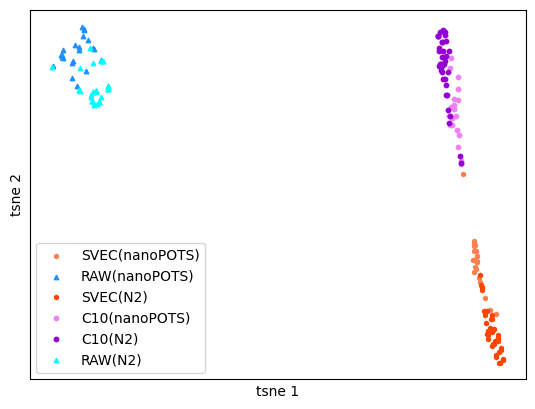

In [9]:
integration_visualization(cell_type_with_dataname,embedding)

### Label transfer
nanoPOTS and N2 are two datasets with the same cell types. After batch effect correction, we can further perform cell type annotation using one dataset as reference and the other as target.
A diagram describing this process is shown below.


<p align="center">
  <img width="50%" src="./image/labeltransfer.png">
</p>



In [10]:
print('transfer from nanoPOTS to N2')


Y_reference = cell_type_label[batch_label==0]
Y_target = cell_type_label[batch_label==1]

X_reference_scPROTEIN = embedding[batch_label==0]
X_target_scPROTEIN = embedding[batch_label==1]

neigh_learned = KNeighborsClassifier(weights='distance')
neigh_learned.fit(X_reference_scPROTEIN, Y_reference)
Y_predict_scPROTEIN = neigh_learned.predict(X_target_scPROTEIN)

print('acc:',accuracy_score(Y_target, Y_predict_scPROTEIN), 'macro-f1:', f1_score(Y_target, Y_predict_scPROTEIN, average='macro'))

transfer from nanoPOTS to N2
acc: 1.0 macro-f1: 1.0


In [11]:
print('transfer from N2 to nanoPOTS')

Y_reference = cell_type_label[batch_label==1]
Y_target = cell_type_label[batch_label==0]

X_reference_scPROTEIN = embedding[batch_label==1]
X_target_scPROTEIN = embedding[batch_label==0]

neigh_learned = KNeighborsClassifier(weights='distance')
neigh_learned.fit(X_reference_scPROTEIN, Y_reference)
Y_predict_scPROTEIN = neigh_learned.predict(X_target_scPROTEIN)

print('acc:',accuracy_score(Y_target, Y_predict_scPROTEIN), 'macro-f1:', f1_score(Y_target, Y_predict_scPROTEIN, average='macro'))

transfer from N2 to nanoPOTS
acc: 0.9836065573770492 macro-f1: 0.982905982905983
